## GEI723, Université de Sherbrooke, Oct. 2020. Jean Rouat

Ce notebook est une adaptation de la classification par STDP de MNIST par Diehl & Cook, créé par I. Balafrej pour l'automne 2019, et adapté par A. El Ferdaoussi pour l'automne 2020.

L'article de Diehl & Cook est disponible ici: https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full

Le modèle est simplifié un peu et réécrit pour Brian2 et Python 3. Le code est à trous, et les parties à compléter sont indiquées par 'COMPLETER'.

ATTENTION: 'exemple donné ici utilise seulement des données d'entrainement et de validation (appelées à tort "test").

Les équations et certains paramètres des neurones sont fournies.

Un exemple d'encodage par fréquence est utilisé (voir la partie "testons à présent le réseau entrainé'). Vous avez toute liberté d'utiliser un autre type d'encodage.

In [43]:
import numpy as np
from sklearn import datasets, model_selection
from brian2 import *
import matplotlib.pyplot as plt
%matplotlib inline

DATA_LIMIT = 200
TEST_SIZE = 50
NUMBER_NODES_PER_LAYER = 100

## Ensemble de données MNIST

On télécharge l'ensemble de données MNIST directement dans le code. MNIST est disponible à https://www.openml.org/d/554

L'argument 'data_home' peut être utilisé pour télécharger MNIST dans un répertoire de votre choix. (Le répertoire par défaut est '~/scikit_learn_data/'.)

In [44]:
X_all, y_all = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, data_home='./data')

MNIST est constituté de 70k d'images de 28x28 pixels, de chiffres.

'X' est le vecteur d'images, et 'y' est le vecteur d'étiquettes (labels).

In [45]:
X_all.shape, y_all.shape

((70000, 784), (70000,))

La simulation avec toutes les images est assez longue à faire rouler. Utilisons uniquement un sous-ensemble de MNIST pour une simulation plus rapide.

In [46]:
X = X_all[:DATA_LIMIT] # Completed
y = y_all[:DATA_LIMIT] # Completed

Divisons MNIST en ensembles d'entrainement et de test pour entrainer et tester le modèle post-apprentissage.

Si on travaille avec l'ensemble au complet, on peut prendre 10k pour le test par exemple.

In [47]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=TEST_SIZE) # Completed

Dessinons une image aléatoire de l'ensemble de données pour voir ce à quoi ressemble MNIST.

Les images dans MNIST sont des vecteurs. Il faut donc les ré-organiser en matrice 28x28 pour les afficher.

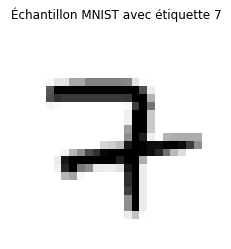

In [48]:
index = np.random.randint(0, len(X_train)-1)

plt.figure()
plt.axis('off')
plt.imshow(X_train[index].reshape(28, 28), cmap=plt.cm.gray_r)
plt.title("Échantillon MNIST avec étiquette %s" % y_train[index]);

## Réseau de neurones Brian2

On peut maintenant créer un réseau Brian2. Commençons par définir quelques paramètres.

In [49]:
# Fixons le seed aléatoire afin de pouvoir reproduire les résultats
np.random.seed(0)

# Horloge de Brian2
defaultclock.dt = 0.5 * units.ms

# Cible de génération de code pour Brian2
prefs.codegen.target = 'cython'

time_per_sample =   0.35 * units.second
resting_time = 0.15 * units.second

v_rest_e = -65. * units.mV 
v_rest_i = -60. * units.mV 

v_reset_e = -65. * units.mV
v_reset_i = -45. * units.mV

v_thresh_e = -52. * units.mV
v_thresh_i = -40. * units.mV

refrac_e = 5. * units.ms
refrac_i = 2. * units.ms

tc_theta = 1e7 * units.ms
theta_plus_e = 0.05 * units.mV

tc_pre_ee = 20 * units.ms
tc_post_1_ee = 20 * units.ms
tc_post_2_ee = 40 * units.ms

# Taux d'apprentissage
nu_ee_pre =  0.1 # [0, 1] Completed
nu_ee_post = 0.1 # [0, 1] Completed

Définissons l'entrée au réseau de neurones. L'entrée est un encodeur de type codage par fréquence.

In [50]:
input_rates = np.ones([1,784])  # Completed
input_group = PoissonGroup(784, rates = input_rates*Hz) # Groupe de Poisson

Définissons notre modèle de neurone ainsi que nos groupes de neurones.

In [51]:
neuron_model = '''
    dv/dt = ((v_rest_e - v) + (I_synE + I_synI) / nS) / tau  : volt (unless refractory)

    I_synE =  ge * nS * -v           : amp
    
    I_synI =  gi * nS * (d_I_synI-v) : amp
    
    dge/dt = -ge/(1.0*ms)            : 1
    
    dgi/dt = -gi/(2.0*ms)            : 1
    
    tau                              : second (constant, shared)
    
    d_I_synI                         : volt (constant, shared)
    
    dtheta/dt = -theta / (tc_theta)  : volt
'''
# Completed
excitatory_group = NeuronGroup(
    N=NUMBER_NODES_PER_LAYER, model=neuron_model, refractory='refrac_e', 
    threshold='v > v_thresh_e + theta', reset='v = v_reset_e; theta += theta_plus_e', method='euler')
excitatory_group.tau = 100 * units.ms
excitatory_group.d_I_synI = -100. * units.mV

# Completed
inhibitory_group = NeuronGroup(
    N=NUMBER_NODES_PER_LAYER, model=neuron_model, refractory='refrac_i', 
    threshold='v > v_thresh_i', reset='v = v_reset_i', method='euler')
inhibitory_group.tau = 10 * units.ms
inhibitory_group.d_I_synI = -85. * mV

Et les synapses.

In [52]:
synapse_model = "w : 1"

synapse_on_pre_i = "ge_post -= w"

synapse_on_pre_e = "gi_post += w" # TODO check

# Completed
stdp_synapse_model = '''
    w : 1

    plastic : boolean (shared) # Activer/désactiver la plasticité
    
    post2before : 1  # x_tar ?

    dpre/dt    = -pre/(tc_pre_ee) : 1 (event-driven)

    dpost1/dt  = -post1/(tc_post_1_ee) : 1 (event-driven)

    dpost2/dt  = -post2/(tc_post_2_ee) : 1 (event-driven)  # (?)

    wmax = 10 : 1  # Completed

    mu = 1 : 1  # Completed
'''

# Completed
stdp_pre = '''
    ge_post += w
    
    pre = 1.
    
    w = clip(w + (nu_ee_pre * post1), 0, wmax)
'''

# Completed
# w = clip(w + nu_ee_post*(pre-post2before)*(wmax - w)**mu, 0, wmax)
stdp_post = '''
    post2before = post2
    
    w = clip(w + (nu_ee_post * pre), 0, wmax)
    
    post1 = -1.

    post2 = 1.
'''

input_synapse = Synapses(input_group, excitatory_group, model=stdp_synapse_model, on_pre=stdp_pre, on_post=stdp_post,
                         method='euler') # Completed
input_synapse.connect(True) # Fully connected
input_synapse.delay = '10 * ms' # Completed
input_synapse.plastic = True
input_synapse.w = 'rand()*10' # Completed

e_i_synapse = Synapses(excitatory_group, inhibitory_group, model=synapse_model, method='euler') # Completed
e_i_synapse.connect(True, p=0.0025)
e_i_synapse.w = 'rand()*10.4'

i_e_synapse = Synapses(inhibitory_group, excitatory_group, model=synapse_model, method='euler') # Completed
i_e_synapse.connect(True, p=0.9)
i_e_synapse.w = 'rand()*17.0'

Combien de synapses a-t-on dans le réseau?

In [53]:
print(len(input_synapse) + len(e_i_synapse) + len(i_e_synapse))

87408


Définissons un 'readout' pour notre réseau.

In [54]:
e_monitor = SpikeMonitor(excitatory_group, record=False)

Créons le réseau.

In [55]:
net = Network(input_group, excitatory_group, inhibitory_group, 
              input_synapse, e_i_synapse, i_e_synapse, e_monitor)

## Entrainement

Entrainons à présent notre réseau.

Créons une matrice 'spikes' pour assigner les étiquettes des classes post-apprentissage. Cette matrice accumulera le décompte de décharges par classe.

Notre readout 'e_monitor' est actif tout le long de la simulation avec toutes les images. Donc à chaque nouvelle présentation d'image, on doit soustraire l'ancien décompte de décharges. On utilisera le vecteur 'old_spike_counts' pour le faire. 

In [56]:
spikes = np.zeros((10, len(excitatory_group)))
old_spike_counts = np.zeros(len(excitatory_group))

# Entrainement
number_of_epochs = 1

for i in range(number_of_epochs):
    print('Starting epoch %i' % i)
    for j, (sample, label) in enumerate(zip(X_train, y_train)):
        # Afficher régulièrement l'état d'avancement
        if (j % 1) == 0:
            print("Running sample %i out of %i" % (j, len(X_train)))

        # Configurer le taux d'entrée
        input_group.rates = sample / 4 * units.Hz # Completed

        # Simuler le réseau
        net.run(time_per_sample)

        # Enregistrer les décharges
        spikes[int(label)] += e_monitor.count - old_spike_counts
        # Gardons une copie du décompte de décharges pour pouvoir calculer le prochain
        old_spike_counts = np.copy(e_monitor.count)
        
        # Arrêter l'entrée
        input_group.rates = 0 * units.Hz
        
        # Laisser les variables retourner à leurs valeurs de repos
        net.run(resting_time)
        
        # Normaliser les poids
        weight_matrix = np.zeros([784, NUMBER_NODES_PER_LAYER]) # Completed
        weight_matrix[input_synapse.i, input_synapse.j] = input_synapse.w
        # weight_matrix = weight_matrix/input_synapse.wmax
        # colFactors = weight_matrix[0] / col_sums
        col_sums = np.sum(weight_matrix, axis=0) # Completed
        colFactors = 1 / col_sums # Completed

        for k in range(len(excitatory_group)):
            weight_matrix[:,k] *= colFactors[k]
        input_synapse.w = weight_matrix[input_synapse.i, input_synapse.j]

Starting epoch 0
Running sample 0 out of 150
Running sample 1 out of 150
Running sample 2 out of 150
Running sample 3 out of 150
Running sample 4 out of 150
Running sample 5 out of 150
Running sample 6 out of 150
Running sample 7 out of 150
Running sample 8 out of 150
Running sample 9 out of 150
Running sample 10 out of 150
Running sample 11 out of 150
Running sample 12 out of 150
Running sample 13 out of 150
Running sample 14 out of 150
Running sample 15 out of 150
Running sample 16 out of 150
Running sample 17 out of 150
Running sample 18 out of 150
Running sample 19 out of 150
Running sample 20 out of 150
Running sample 21 out of 150
Running sample 22 out of 150
Running sample 23 out of 150
Running sample 24 out of 150


KeyboardInterrupt: 

## Test

Commençons par trouver le meilleur neurone pour chaque classe de MNIST.

In [ ]:
labeled_neurons = np.argmax(spikes, axis=1)

labeled_neurons

Testons à présent le réseau entrainé!

In [ ]:
# Déasctiver la plasticité STDP
input_synapse.plastic = False

num_correct_output = 0

for i, (sample, label) in enumerate(zip(X_test, y_test)):
    # Afficher régulièrement l'état d'avancement
    if (i % 10) == 0:
        print("Running sample %i out of %i" % (i, len(X_test)))
    
    # Configurer le taux d'entrée
    # ATTENTION, vous pouvez utiliser un autre type d'encodage
    input_group.rates = sample / 4 * units.Hz # Completed
    
    # Simuler le réseau
    net.run(time_per_sample)
    
    # Calculer le nombre de décharges pour l'échantillon
    current_spike_count = e_monitor.count - old_spike_counts
    # Gardons une copie du décompte de décharges pour pouvoir calculer le prochain
    old_spike_counts = np.copy(e_monitor.count)
    
    # Prédire la classe de l'échantillon
    output_label = np.argmax(COMPLETER) # Completed

    # Si la prédiction est correcte
    if output_label == int(label):
        num_correct_output += 1
        
    # Laisser les variables retourner à leurs valeurs de repos
    net.run(resting_time)

    
print("The model accuracy is : %.3f" % (num_correct_output / len(X_test)))    